<a href="https://colab.research.google.com/github/JoaoGranja/CIFAR10_ImageClassification/blob/master/image_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = False


# **Colab Preparation** 
Before handling the project, we need to install keras and pip packages. I also share my google drive to simplify the connection with my google drive account.



In [2]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    !pip install --upgrade keras
    !pip install keras-resnet

    from google.colab import drive
    drive.mount('/content/drive')

 # **Configuration and imports**

First thing I do is to import all modules we need for this project. I also use some configuration parameters to be used through the project

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling. Another important library to handle image data is Opencv.



In [3]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# image procesing library
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import cv2 

# tensorflow and keras for CNN model
import tensorflow as tf
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
from keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD
from keras import backend as K
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.datasets import cifar10
#from keras.utils import multi_gpu_model
from keras.preprocessing.image import Iterator, load_img, img_to_array

if is_colab:
    from google.colab import files
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['data_augmentation'] = False

#training arguments
args['batch_size'] = 32
args['epochs'] = 5
args['validation_split'] = 0.2

#model arguments
#args['network'] = 'LeNet'
#args['network'] = 'resnet50'
args['network'] = 'VGG19'

#optimizer arguments
#args['optimizer'] = 'adam'
args['learning_rate'] = 0.01  
args['decay'] = 0.0001
args['loss'] = 'sparse_categorical_crossentropy'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Loading the dataset

In this project I will use the CIFAR10 dataset which is comprised of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class labels and their standard associated integer values are listed below. More information is available on [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html)

<ul>
<li> 0: airplane </li>
<li> 1: automobile </li>
<li> 2: bird </li>
<li> 3: cat </li>
<li> 4: deer </li>
<li> 5: dog </li>
<li> 6: frog </li>
<li> 7: horse </li>
<li> 8: ship </li>
<li> 9: truck </li>
</ul>

In [4]:
def unpickle(file):
    with open(file, 'rb') as data:
        dataset = pickle.load(data)
    return dataset

In [5]:
#------------------------------  Load dataset using keras.dataset API -----------------------------------#
download_dataset = False
if download_dataset:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    dataset = {}
    dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test'] = x_train, y_train, x_test, y_test
    with open('dataset/cifar10.pickle', 'wb') as output:
        pickle.dump(dataset, output)
else:
    dataset = unpickle('dataset/cifar10.pickle')
    #(x_train, y_train), (x_test, y_test) = (dataset['x_train'][:5000], dataset['y_train'][:5000]), (dataset['x_test'][:1000], dataset['y_test'][:1000])
    (x_train, y_train), (x_test, y_test) = (dataset['x_train'], dataset['y_train']), (dataset['x_test'], dataset['y_test'])


#Check train and test dataset shape
print("Train dataset: x={} y={}".format(x_train.shape, y_train.shape))
print("Test dataset: x={} y={}".format(x_test.shape, y_test.shape))

#Check number of classes and image shape
print("Image data shape =", x_train.shape[1:])
print("Number of classes =",  len(np.unique(y_train)))

#Class dictionary with classes names
class_names = {}
class_names[0] = 'airplane'
class_names[1] = 'automobile'
class_names[2] = 'bird'
class_names[3] = 'cat'
class_names[4] = 'deer'
class_names[5] = 'dog'
class_names[6] = 'frog'
class_names[7] = 'horse'
class_names[8] = 'ship'
class_names[9] = 'truck'

Train dataset: x=(50000, 32, 32, 3) y=(50000, 1)
Test dataset: x=(10000, 32, 32, 3) y=(10000, 1)
Image data shape = (32, 32, 3)
Number of classes = 10


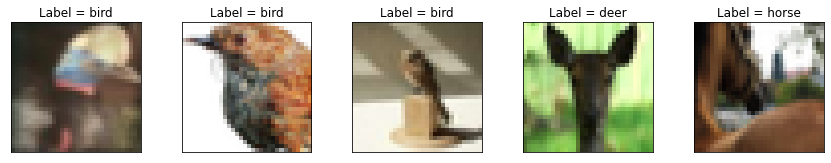

In [6]:
#------------------------------ Plot random images and respective labels -----------------------------------#
n_images = 5
fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)
   
for i in range(n_images):
    index = random.randint(0, len(x_train))
    image = x_train[index].squeeze()

    axs[i].imshow(image)
    axs[i].set_title("Label = {0}".format(class_names[int(y_train[index])]))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)


Analyzing the images it is clear that the images resolution is small, actually 32x32 has few pixels and therefore can be a challenge for a model to classify correctly the object. Furthermore all image has the same size so it is not required to resize the input images.

# **Pre-processing the train and test dataset**

In [7]:
from aug.functional import transform_image, normalize_image
x_train_ = x_train
y_train_ = y_train

#------------------------------ Random data augmentation -----------------------------------#
if args['data_augmentation']:
    data_aug_samples = 3
    for i in range(data_aug_samples):
        x_train_ = np.vstack((x_train_,transform_image(x_train)))
        y_train_ = np.vstack((y_train_,y_train))

    #Check train dataset shape
    print("Train dataset: x={} y={}".format(x_train_norm.shape, y_train_.shape))

#------------------------------ Normalization of images dataset -----------------------------------#
x_test_norm = normalize_image(x_test)
x_train_norm = normalize_image(x_train_)

#------------------------------ Remove old varibles -----------------------------------#
del x_test, x_train, y_train
x_train, y_train, x_test = x_train_norm, y_train_, x_test_norm
del x_train_norm, y_train_, x_test_norm
gc.collect

# **Optimizer**

Before training it is necessary to choose an optimizer which will be responsible to adjust model parameters in order to reduce the loss funcion

In [8]:
#------------------------------ Define an optimizer -----------------------------------#
if 'optimizer' in args:
    if args['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'amsgrad':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
    elif args['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

# **Model**

In this project, I will first use a simple CNN model following the LeNet architecture.

In [9]:
from models.model_factory import make_model

#------------------------------ Make the model -----------------------------------#
if 'multi_gpu' in args:
    with K.tf.device("/cpu:0"):
        model = make_model(args['network'], x_train.shape[1:])
else:
    model = make_model(args['network'], x_train.shape[1:], len(np.unique(y_train)))
    
if 'weights' not in args:
    print('No weights passed, training from scratch')
else:
    weights_path = args['weights']
    print('Loading weights from {}'.format(weights_path))
    model.load_weights(weights_path, by_name=True)

#------------------------------ Compile the model -----------------------------------#
model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 
model.summary()

No weights passed, training from scratch
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.nn.convolution (TFOpLambd (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.convolution_1 (TFOpLam (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.relu_1 (TFOpLa

# **Training**

In [10]:
#------------------------------ Model check points -----------------------------------#
args['models_dir'] = 'nn_models_checkpoints'
best_model_file = '{}/best_{}.h5'.format(args['models_dir'], args['network'])
last_model_file = '{}/last_{}.h5'.format(args['models_dir'], args['network'])

#------------------------------ Callbacks -----------------------------------#
callbacks = [
        # Callback to reduce the learning rate once the plateau has been reached:
        ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            mode='auto',
            cooldown=0,
            min_lr=1e-8
        ),
        # Callback to stop the training once no more improvements are recorded:
        EarlyStopping(
            min_delta=0.001,
            patience=4,
            mode='auto',
            restore_best_weights=True
        ),
        # Callback to log the graph, losses and metrics into TensorBoard:
        TensorBoard(log_dir="logs/{}".format(args['network'])
        ),
        # Callback to save the best and last model specifying the epoch and val-loss in the filename:
        ModelCheckpoint(filepath=last_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=False,
            save_weights_only=True
        ),
        ModelCheckpoint(filepath=best_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=True,
            save_weights_only=True)
    ]

#------------------------------ Model Fit -----------------------------------#
history = model.fit(x_train, y_train,
                    validation_split=args['validation_split'],
                    epochs=args['epochs'], 
                    batch_size=args['batch_size'], 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
1250/1250 [==============================] - 472s 361ms/step - loss: 1.4464 - accuracy: 0.5032 - val_loss: 1.2709 - val_accuracy: 0.5757

Epoch 00001: saving model to nn_models_checkpoints/last_VGG19.h5

Epoch 00001: val_loss improved from inf to 1.27088, saving model to nn_models_checkpoints/best_VGG19.h5
Epoch 2/5
1250/1250 [==============================] - 413s 331ms/step - loss: 1.2449 - accuracy: 0.5830 - val_loss: 1.2894 - val_accuracy: 0.5794

Epoch 00002: saving model to nn_models_checkpoints/last_VGG19.h5

Epoch 00002: val_loss did not improve from 1.27088
Epoch 3/5
1250/1250 [==============================] - 446s 357ms/step - loss: 1.2365 - accuracy: 0.5955 - val_loss: 1.3757 - val_accuracy: 0.5645

Epoch 00003: saving model to nn_models_checkpoints/last_VGG19.h5

Epoch 00003: val_loss did not improve from 1.27088
Epoch 4/5
1250/1250 [==============================] - 430s 344ms/step - loss: 1.2350 - accuracy: 0.5965 - val_loss: 1.2923 - val_accuracy: 0.5856

Epoc

# **Visualise Model Results**

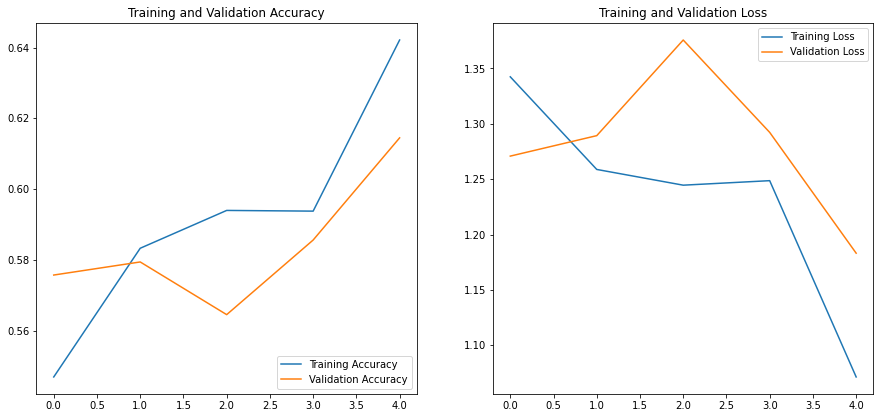

In [11]:
#------------------------------ Plot diagnostic learning curves -----------------------------------#
def summarize_diagnostics(history):
    # plot loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(args['epochs'])

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    # save plot to file
    filename = "accuracy"
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()
    
summarize_diagnostics(history)


# **Evaluation**

Evaluate the model over the test dataset. We will use the last model weights and predict the class for some test images

nn_models_checkpoints/last_VGG19.h5


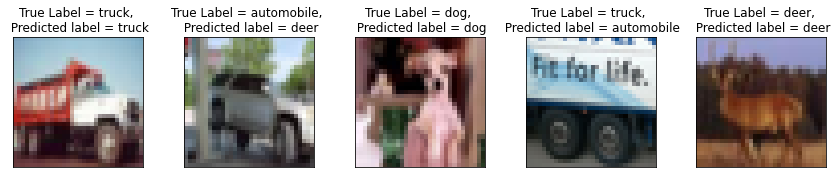

In [12]:
#------------------------------ Predict on some test images -----------------------------------#

#Load last model parameters
print(last_model_file)
model.load_weights(last_model_file, by_name=True)

#Try out the model on an image from the test data:
n_images = 5
fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)

        
# View the images
for i in range(n_images):
    index = random.randint(0, len(x_test))
    image = x_test[index].squeeze()
    true_index = int(y_test[index])

    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    
    image = np.add(image*128,128).astype(int)
    axs[i].imshow(image)
    axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(class_names[true_index], class_names[predicted_index]))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)



In [ ]:
#------------------------------ Evaluate model on training and testing dataset -----------------------------------#

_, acc = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy = {}".format(acc))

_, acc = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy = {}".format(acc))

Training Accuracy = 0.6419000029563904
